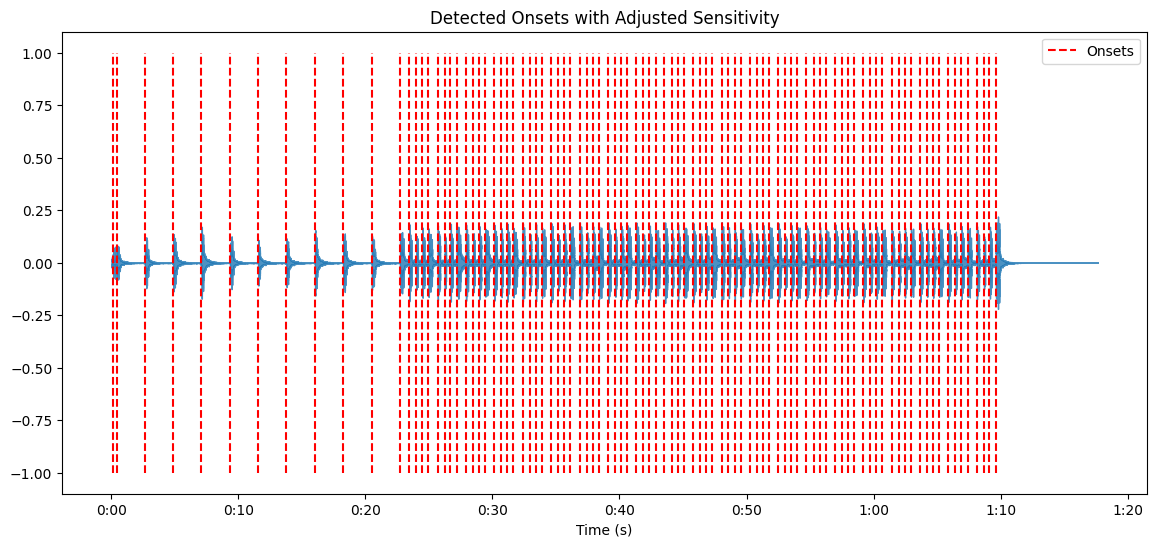

Onset times (in seconds): [ 0.11029478  0.40054422  2.61804989  4.85877551  7.08208617  9.32281179
 11.52870748 13.7752381  16.01596372 18.21024943 20.48580499 22.70911565
 23.43473923 23.98621315 24.4738322  24.95564626 25.68126984 26.22693878
 26.67972789 27.17315193 27.9045805  28.46185941 28.9262585  29.41968254
 30.15111111 30.69097506 31.13795918 31.6429932  32.37442177 32.9200907
 33.39609977 33.88952381 34.61514739 35.16081633 35.60199546 36.11283447
 36.861678   37.41315193 37.889161   38.37678005 39.10820862 39.64807256
 40.09505669 40.6000907  41.33151927 41.87718821 42.35319728 42.84081633
 43.53741497 44.11791383 44.57070295 45.06993197 45.79555556 46.35283447
 46.81723356 47.3106576  48.04208617 48.58195011 49.05795918 49.53396825
 50.26539683 50.81687075 51.28126984 51.78049887 52.50612245 53.04598639
 53.51038549 53.99800454 54.71782313 55.28671202 55.76852608 56.24453515
 56.96435374 57.51002268 57.97442177 58.4678458  59.17024943 59.7507483
 60.23256236 60.6737415  61

In [7]:
# Import necessary libraries
import librosa
import librosa.display
import matplotlib.pyplot as plt
import requests

# Download the file to a local path
# audio_url = 'https://github.com/egorpol/beat_it/raw/refs/heads/main/examples/Dufour_full_mono.aif'
local_audio_path = 'examples/Dufour_full_mono.aif'

# # Download the file
# response = requests.get(audio_url)
# with open(local_audio_path, 'wb') as f:
#     f.write(response.content)

# Define the hop length globally
hop_length = 128

# Load the audio file
y, sr = librosa.load(local_audio_path)

# Onset detection with custom sensitivity
onset_frames = librosa.onset.onset_detect(y=y, sr=sr,
                                          delta=0.12,       # Lower value for more sensitivity (default is 0.07)
                                          backtrack=True,   # Enable backtracking to improve onset timing
                                          pre_max=10,       # Increase to be less sensitive to nearby peaks
                                          post_max=10,      # Increase for less sensitivity to nearby peaks
                                          hop_length=hop_length)  # Use global hop length

# Convert onset frames to times
onset_times = librosa.frames_to_time(onset_frames, sr=sr, hop_length=hop_length)  # Use global hop length

# Plot the waveform and onset times
plt.figure(figsize=(14, 6))
librosa.display.waveshow(y, sr=sr, alpha=0.8)
plt.vlines(onset_times, ymin=-1, ymax=1, color='r', linestyle='--', label='Onsets')
plt.title('Detected Onsets with Adjusted Sensitivity')
plt.xlabel('Time (s)')
plt.legend()
plt.show()

# Print the onset times
print('Onset times (in seconds):', onset_times)


In [4]:
import numpy as np

# Desired interval and tolerance
interval = 2.23    # Desired interval in seconds
tolerance = 0.15   # Tolerance in seconds

# Build a directed acyclic graph (DAG) where nodes are onset times
edges = {t: [] for t in onset_times}

# Construct edges between onset times that are approximately 'interval' apart
for i in range(len(onset_times)):
    for j in range(i + 1, len(onset_times)):
        delta_t = onset_times[j] - onset_times[i]
        if abs(delta_t - interval) <= tolerance:
            edges[onset_times[i]].append(onset_times[j])

# Function to find the longest path starting from a given node
def find_longest_path(node, edges, memo):
    if node in memo:
        return memo[node]
    max_length = 1
    max_path = [node]
    for neighbor in edges[node]:
        path = find_longest_path(neighbor, edges, memo)
        if 1 + len(path) > max_length:
            max_length = 1 + len(path)
            max_path = [node] + path
    memo[node] = max_path
    return max_path

# Find all longest sequences in the DAG
memo = {}
longest_length = 0
longest_paths = []

for node in onset_times:
    path = find_longest_path(node, edges, memo)
    if len(path) > longest_length:
        longest_length = len(path)
        longest_paths = [path]
    elif len(path) == longest_length:
        longest_paths.append(path)

# Store sequences in a list
sequences = [np.array(path) for path in longest_paths]

# Output all sequences that have the longest length
for idx, seq in enumerate(sequences):
    print(f"Sequence {idx + 1}:")
    print(seq)

Sequence 1:
[ 0.40054422  2.61804989  4.85877551  7.08208617  9.32281179 11.52870748
 13.7752381  16.01596372 18.21024943 20.48580499 22.70911565 24.95564626
 27.17315193 29.41968254 31.6429932  33.88952381 36.11283447 38.37678005
 40.6000907  42.84081633 45.06993197 47.3106576  49.53396825 51.78049887
 53.99800454 56.24453515 58.4678458  60.6737415  62.93768707 65.15519274
 67.40172336 69.62503401]


In [5]:
# Example of accessing a specific sequence
if sequences:
    first_sequence = sequences[0]
    print("First Sequence:", first_sequence)

First Sequence: [ 0.40054422  2.61804989  4.85877551  7.08208617  9.32281179 11.52870748
 13.7752381  16.01596372 18.21024943 20.48580499 22.70911565 24.95564626
 27.17315193 29.41968254 31.6429932  33.88952381 36.11283447 38.37678005
 40.6000907  42.84081633 45.06993197 47.3106576  49.53396825 51.78049887
 53.99800454 56.24453515 58.4678458  60.6737415  62.93768707 65.15519274
 67.40172336 69.62503401]


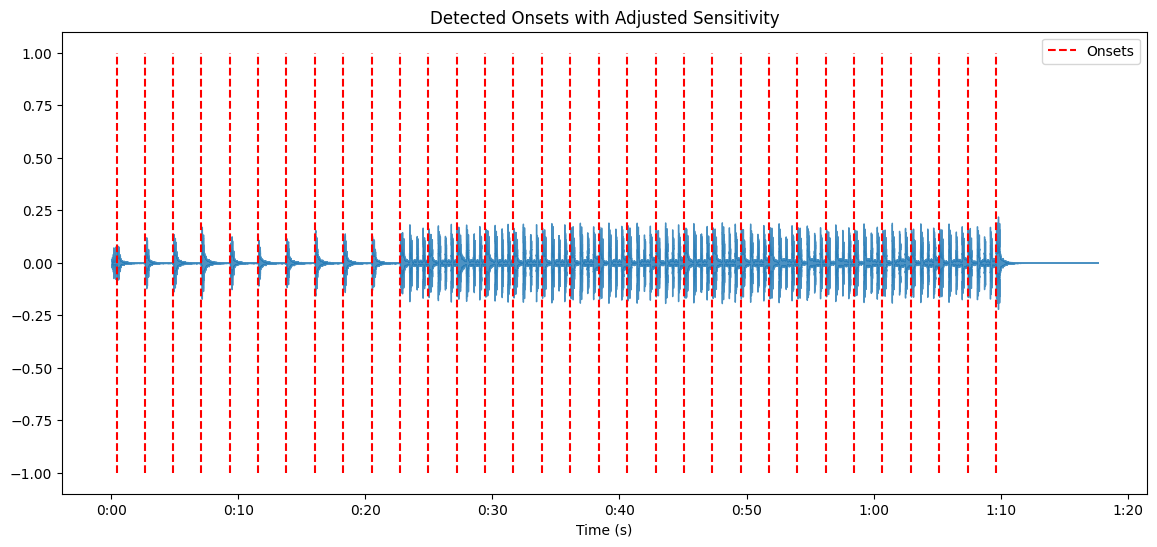

In [6]:
plt.figure(figsize=(14, 6))
librosa.display.waveshow(y, sr=sr, alpha=0.8)
plt.vlines(first_sequence, ymin=-1, ymax=1, color='r', linestyle='--', label='Onsets')
plt.title('Detected Onsets with Adjusted Sensitivity')
plt.xlabel('Time (s)')
plt.legend()
plt.show()

In [ ]:
import pandas as pd

# Create a DataFrame
df_seq = pd.DataFrame({"onset_times": onset_times})


# Define the file path
file_path = 'dufour_onsets_librosa_unfiltered.csv'

# Save the DataFrame to a CSV file
df_seq.to_csv(file_path, index=False)

# Print the dynamic message
print(f"Sequence has been saved to '{file_path}'")

Sequence has been saved to 'dufour_onsets_librosa_unfiltered.csv'
